<a href="https://colab.research.google.com/github/Dagnachew12/Hello-world/blob/main/DeepResUnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import gc
import cv2
import time
import tqdm
import random
import collections
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image
from functools import partial
import matplotlib.pyplot as plt
from tqdm.auto import tqdm as tq
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

In [2]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim import lr_scheduler
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import TensorDataset, DataLoader, Dataset
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau
import glob

# ablumentations for easy image augmentation for input as well as output
import albumentations as albu
# from albumentations import torch as AT
plt.style.use('bmh')

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!unzip '/content/drive/MyDrive/Brain_tumor_segmentation.zip' -d './Data'

Archive:  /content/drive/MyDrive/Brain_tumor_segmentation.zip
   creating: ./Data/data/
  inflating: ./Data/data/Y1.jpg      
  inflating: ./Data/data/Y1.png      
  inflating: ./Data/data/Y10.jpg     
  inflating: ./Data/data/Y10.png     
  inflating: ./Data/data/Y100.jpg    
  inflating: ./Data/data/Y100.png    
  inflating: ./Data/data/Y101.jpg    
  inflating: ./Data/data/Y101.png    
  inflating: ./Data/data/Y102.jpg    
  inflating: ./Data/data/Y102.png    
  inflating: ./Data/data/Y103.jpg    
  inflating: ./Data/data/Y103.png    
  inflating: ./Data/data/Y104.jpg    
  inflating: ./Data/data/Y104.png    
  inflating: ./Data/data/Y105.jpg    
  inflating: ./Data/data/Y105.png    
  inflating: ./Data/data/Y106.jpg    
  inflating: ./Data/data/Y106.png    
  inflating: ./Data/data/Y107.jpg    
  inflating: ./Data/data/Y107.png    
  inflating: ./Data/data/Y108.jpg    
  inflating: ./Data/data/Y108.png    
  inflating: ./Data/data/Y109.jpg    
  inflating: ./Data/data/Y109.png    


In [5]:
images_path = sorted(glob.glob("./Data/data/*.jpg"))
labels_path = sorted(glob.glob("./Data/data/*.png"))

In [6]:
print(len(images_path))
print(len(labels_path))
print(images_path[18])
print(labels_path[18])

148
148
./Data/data/Y116.jpg
./Data/data/Y116.png


In [7]:
class CustomDataset(Dataset):
  def __init__(self, imagePaths, maskPaths, transforms):
    self.imagePaths = imagePaths
    self.maskPaths = maskPaths
    self.transforms = transforms
  def __len__(self):
    return len(self.imagePaths)
  def __getitem__(self, idx):
    imagePath = self.imagePaths[idx]
    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    mask = cv2.imread(self.maskPaths[idx], 0)
    if self.transforms is not None:
      image = self.transforms(image)
      mask = self.transforms(mask)
    return (image, mask)

In [8]:
imagePaths = images_path
maskPaths = labels_path
split = train_test_split(imagePaths, maskPaths,test_size=0.2, shuffle=True)
(trainImages, testImages) = split[:2]
(trainMasks, testMasks) = split[2:]

print(testImages)
print(testMasks)

['./Data/data/Y23.jpg', './Data/data/Y27.jpg', './Data/data/Y33.jpg', './Data/data/Y76.jpg', './Data/data/Y53.jpg', './Data/data/Y252.jpg', './Data/data/Y180.jpg', './Data/data/Y41.jpg', './Data/data/Y117.jpg', './Data/data/Y97.jpg', './Data/data/Y78.jpg', './Data/data/Y26.jpg', './Data/data/Y7.jpg', './Data/data/Y34.jpg', './Data/data/Y25.jpg', './Data/data/Y11.jpg', './Data/data/Y4.jpg', './Data/data/Y49.jpg', './Data/data/Y107.jpg', './Data/data/Y147.jpg', './Data/data/Y60.jpg', './Data/data/Y89.jpg', './Data/data/Y16.jpg', './Data/data/Y31.jpg', './Data/data/Y166.jpg', './Data/data/Y157.jpg', './Data/data/Y38.jpg', './Data/data/Y70.jpg', './Data/data/Y115.jpg', './Data/data/Y258.jpg']
['./Data/data/Y23.png', './Data/data/Y27.png', './Data/data/Y33.png', './Data/data/Y76.png', './Data/data/Y53.png', './Data/data/Y252.png', './Data/data/Y180.png', './Data/data/Y41.png', './Data/data/Y117.png', './Data/data/Y97.png', './Data/data/Y78.png', './Data/data/Y26.png', './Data/data/Y7.png', 

In [9]:
# define transformations
import torchvision.transforms as transforms
transforms = transforms.Compose([transforms.ToPILImage(),transforms.Resize((256,256)),transforms.ToTensor()])

# create the train and test datasets
trainDS = CustomDataset(imagePaths=trainImages, maskPaths=trainMasks, transforms=transforms)
testDS = CustomDataset(imagePaths=testImages, maskPaths=testMasks, transforms=transforms)
print(f"[INFO] found {len(trainDS)} examples in the training set...")
print(f"[INFO] found {len(testDS)} examples in the test set...")

# create the training and test data loaders
trainLoader = DataLoader(trainDS, shuffle=True, batch_size=1)
testLoader = DataLoader(testDS, shuffle=False,batch_size=1)

[INFO] found 118 examples in the training set...
[INFO] found 30 examples in the test set...


In [10]:
sample = next(iter(testLoader))
print(sample[0][0].shape)
sam = next(iter(trainLoader))
print(sam[1][0].shape)

torch.Size([3, 256, 256])
torch.Size([1, 256, 256])


torch.Size([256, 256, 3])


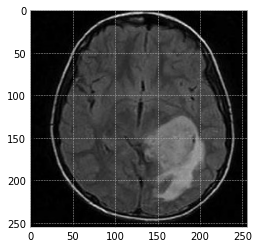

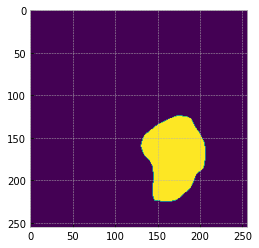

In [11]:
for i in range(len(sample[1])):
  img = sample[0][i]
  img = img.permute(1,2,0).squeeze(2)
  msk = sample[1][i].squeeze(0)
  print(img.shape)
  plt.imshow(img)
  plt.show()
  plt.imshow(msk)
  plt.show()

In [12]:
class PreActivateDoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(PreActivateDoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.BatchNorm2d(in_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        )

    def forward(self, x):
        return self.double_conv(x)

In [13]:
class PreActivateResUpBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(PreActivateResUpBlock, self).__init__()
        self.ch_avg = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(out_channels))
        self.up_sample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.ch_avg = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(out_channels))
        self.double_conv = PreActivateDoubleConv(in_channels, out_channels)

    def forward(self, down_input, skip_input):
        x = self.up_sample(down_input)
        x = torch.cat([x, skip_input], dim=1)
        return self.double_conv(x) + self.ch_avg(x)

In [14]:
class PreActivateResBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(PreActivateResBlock, self).__init__()
        self.ch_avg = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(out_channels))

        self.double_conv = PreActivateDoubleConv(in_channels, out_channels)
        self.down_sample = nn.MaxPool2d(2)

    def forward(self, x):
        identity = self.ch_avg(x)
        out = self.double_conv(x)
        out = out + identity
        return self.down_sample(out), out

In [32]:
class DeepResUNet(nn.Module):
    def __init__(self, out_classes=1):
        super(DeepResUNet, self).__init__()

        self.down_conv1 = PreActivateResBlock(3, 64)
        self.down_conv2 = PreActivateResBlock(64, 128)
        self.down_conv3 = PreActivateResBlock(128, 256)
        self.down_conv4 = PreActivateResBlock(256, 512)

        self.double_conv = PreActivateDoubleConv(512, 1024)

        self.up_conv4 = PreActivateResUpBlock(512 + 1024, 512)
        self.up_conv3 = PreActivateResUpBlock(256 + 512, 256)
        self.up_conv2 = PreActivateResUpBlock(128 + 256, 128)
        self.up_conv1 = PreActivateResUpBlock(128 + 64, 64)

        self.conv_last = nn.Conv2d(64, out_classes, kernel_size=1)

    def forward(self, x):
        x, skip1_out = self.down_conv1(x)
        x, skip2_out = self.down_conv2(x)
        x, skip3_out = self.down_conv3(x)
        x, skip4_out = self.down_conv4(x)
        x = self.double_conv(x)
        x = self.up_conv4(x, skip4_out)
        x = self.up_conv3(x, skip3_out)
        x = self.up_conv2(x, skip2_out)
        x = self.up_conv1(x, skip1_out)
        x = self.conv_last(x)
        return x

In [33]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = DeepResUNet().float()
model = model.to(device)
out = torch.randn(1,3,256,256)
out = out.to(device)
out = model(out)
print(out.shape)

torch.Size([1, 1, 256, 256])


In [34]:
from torch.autograd import variable
import gc
del variable
gc.collect()

1592

In [35]:
def dice_coef_metric(inputs, target):
    intersection = 2.0 * (target*inputs).sum()
    union = target.sum() + inputs.sum()
    if target.sum() == 0 and inputs.sum() == 0:
        return 1.0 
    return intersection/union

In [36]:
class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = torch.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        
        return 1 - dice

In [37]:
def compute_iou(model, loader, threshold=0.3):
    valloss = 0
    valid_loss = 0
    
    with torch.no_grad():

        for i_step, (data, target) in enumerate(loader):
            
            data = data.to(device)
            target = target.to(device)
            
            outputs = model(data)

            out_cut = np.copy(outputs.data.cpu().numpy())
            out_cut[np.nonzero(out_cut < threshold)] = 0.0
            out_cut[np.nonzero(out_cut >= threshold)] = 1.0
            picloss = dice_coef_metric(out_cut, target.data.cpu().numpy())
            valloss += picloss

    return valloss/i_step

In [38]:
train_loss = DiceLoss()

In [39]:
def train_model(model_name, model, train_loader, val_loader, train_loss, optimizer, lr_scheduler, num_epochs):
    print(f"[INFO] Model is initializing... {model_name}")
    
    loss_history = []
    train_history = []
    val_history = []
    
    for epoch in range(num_epochs):
        model.train()
        
        losses = []
        train_iou = []
        
        for i_step, (data, target) in enumerate(train_loader):
            data = data.to(device)
            target = target.to(device)
            
            outputs = model(data)
            out_cut = np.copy(outputs.data.cpu().numpy())
            out_cut[np.nonzero(out_cut < 0.5)] = 0.0
            out_cut[np.nonzero(out_cut >= 0.5)] = 1.0
            
            train_dice = dice_coef_metric(out_cut, target.data.cpu().numpy())
            
            loss = train_loss(outputs, target)
            
            losses.append(loss.item())
            train_iou.append(train_dice)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        val_mean_iou = compute_iou(model, val_loader)
        loss_history.append(np.array(losses).mean())
        train_history.append(np.array(train_iou).mean())
        val_history.append(val_mean_iou)
        
        print("Epoch [%d]" % (epoch))
        print("Mean loss on train:", np.array(losses).mean(), 
              "\nMean DICE on train:", np.array(train_iou).mean(), 
              "\nMean DICE on validation:", val_mean_iou)
        
    return loss_history, train_history, val_history

In [40]:
opt = torch.optim.Adamax(model.parameters(), lr=1e-4)
num_ep = 50
# after 30 does not improve much
aun_lh, aun_th, aun_vh = train_model("Attention UNet", model, trainLoader, testLoader, DiceLoss(), opt, False, num_ep)

[INFO] Model is initializing... Attention UNet
Epoch [0]
Mean loss on train: 0.5023965815366325 
Mean DICE on train: 0.5938293498766453 
Mean DICE on validation: 0.7590788804467117
Epoch [1]
Mean loss on train: 0.30244424231981826 
Mean DICE on train: 0.7149872478346817 
Mean DICE on validation: 0.7129278674688209
Epoch [2]
Mean loss on train: 0.24031952074018575 
Mean DICE on train: 0.770114813708881 
Mean DICE on validation: 0.8042565540937616
Epoch [3]
Mean loss on train: 0.19945981643967708 
Mean DICE on train: 0.80790775930467 
Mean DICE on validation: 0.7966459411707381
Epoch [4]
Mean loss on train: 0.16070350651013648 
Mean DICE on train: 0.8463910247254527 
Mean DICE on validation: 0.7813853063499551
Epoch [5]
Mean loss on train: 0.1361512794332989 
Mean DICE on train: 0.8688709823286751 
Mean DICE on validation: 0.8237804710128899
Epoch [6]
Mean loss on train: 0.11060997944767192 
Mean DICE on train: 0.8949980008470504 
Mean DICE on validation: 0.8245187854915069
Epoch [7]
Mea

In [41]:
MODEL_PATH = 'model.pth'
# serialize the model to disk
torch.save(model, MODEL_PATH)

In [42]:
def test(model):
  for i, (image, mask) in enumerate(testLoader):
    img = image.to(device)
    tru_mask = mask.to(device)
    tru_mask = tru_mask.squeeze(1)
    tru_mask = tru_mask[0]

    prediction = model(img)

    tru_mask= tru_mask.cpu()
    prediction = prediction.squeeze(1)
    prediction = prediction[0]
    prediction = prediction.cpu()
    prediction -= torch.min(prediction)
    prediction /= torch.max(prediction)
    prediction = prediction>0.5
    temp = torch.zeros((256, 512))

    temp[:, 0:256] = tru_mask
    temp[:, 256:512] = prediction
    plt.imshow(temp.cpu())
    plt.show()


In [ ]:
from torch.autograd import variable
import gc
del variable
gc.collect()

0

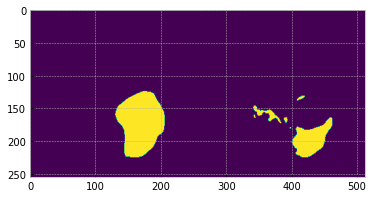

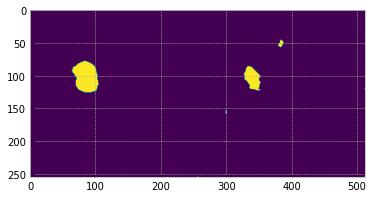

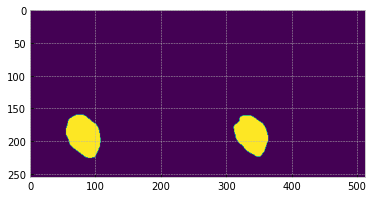

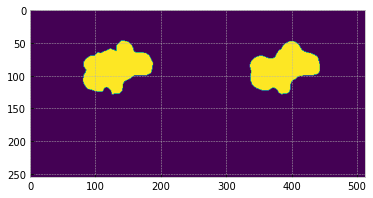

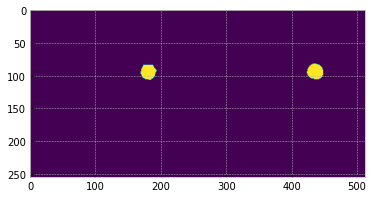

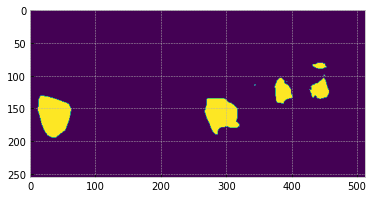

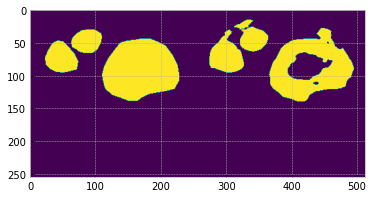

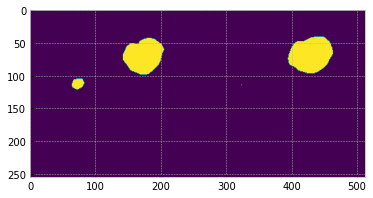

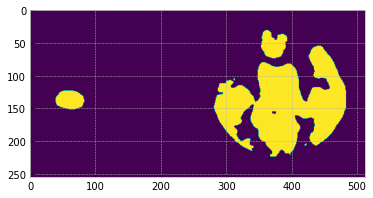

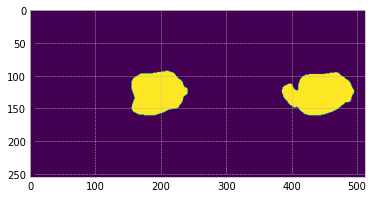

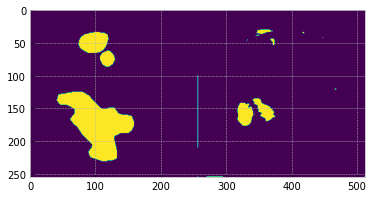

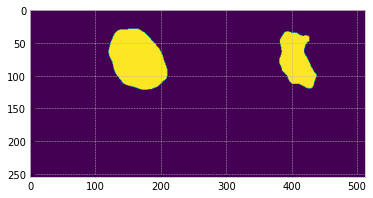

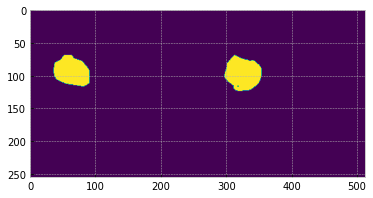

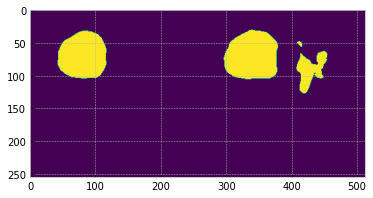

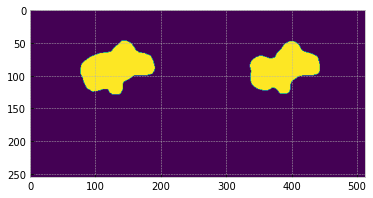

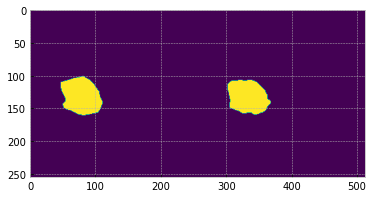

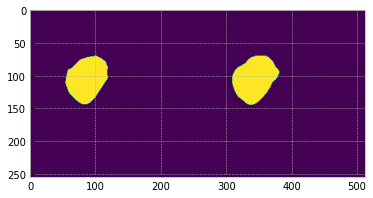

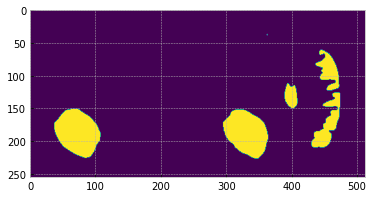

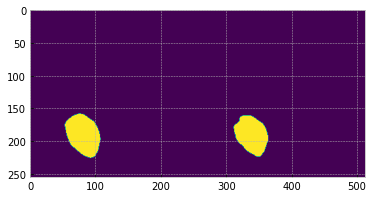

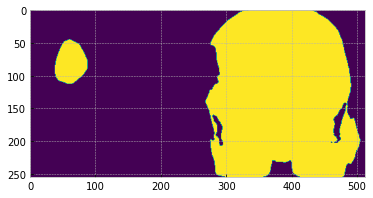

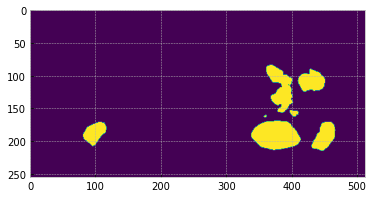

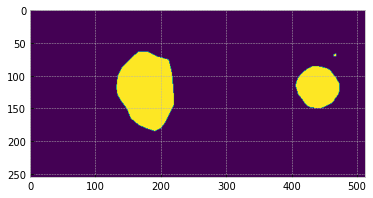

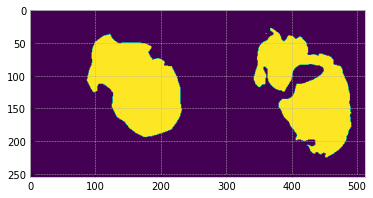

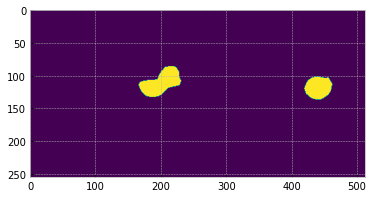

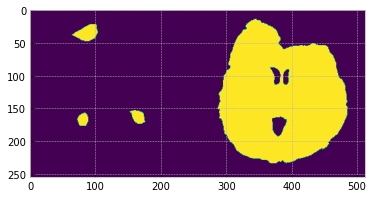

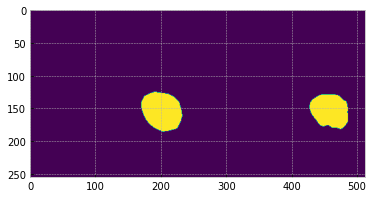

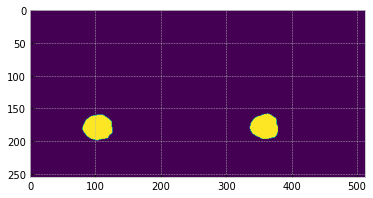

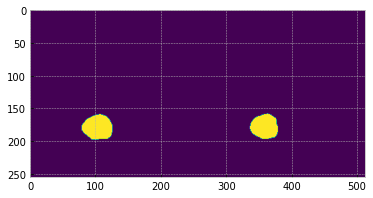

OutOfMemoryError: ignored

In [43]:
model = torch.load('model.pth')
model.eval()
test(model)
